# How to use WEAC v2

Note that instructions in this notebook refer to **release v2.6.1**. Please make sure you are running the latest version of weac using
```sh
pip install -U weac
```

### About the project
---
WEAC implements closed-form analytical models for the [mechanical analysis of dry-snow slabs on compliant weak layers](https://doi.org/10.5194/tc-14-115-2020), the [prediction of anticrack onset](https://doi.org/10.5194/tc-14-131-2020), and, in particular, allwos for stratified snow covers. The model covers propagation saw tests (a), and uncracked (b) or cracked (c) skier-loaded buried weak layers.

<p align="left"><img src="../img/systems.png" width="500"/></p>

Please refer to the companion papers for model derivations, illustrations, dimensions, material properties, and kinematics:

- Rosendahl, P. L., & Weißgraeber, P. (2020). Modeling snow slab avalanches caused by weak-layer failure – Part 1: Slabs on compliant and collapsible weak layers. The Cryosphere, 14(1), 115–130. https://doi.org/10.5194/tc-14-115-2020
- Rosendahl, P. L., & Weißgraeber, P. (2020). Modeling snow slab avalanches caused by weak-layer failure – Part 2: Coupled mixed-mode criterion for skier-triggered anticracks. The Cryosphere, 14(1), 131–145. https://doi.org/10.5194/tc-14-131-2020

Written in 🐍 [Python](https://www.python.org) and built with <span style="color:#498B60">⚛</span> [Atom](https://atom.io), 🐙 [GitKraken](https://www.gitkraken.com), and 🪐 [Jupyter](https://jupyter.org). Note that [release v1.0](https://github.com/2phi/weac/releases/tag/v1.0.0) was written and built in 🌋 [MATLAB](https://www.mathworks.com/products/matlab.html).

### Installation
---
Install `weac` using the `pip` Package Installer for Python
```sh
pip install -U weac
```
To install all resources required for running `weac` interactively such as in this demo, use
```sh
pip install -U 'weac[interactive]'
```
You may also clone the repo, source `weac` locally, and install dependencies manually
```sh
git clone https://github.com/2phi/weac
```

Needs
- [Numpy](https://numpy.org/) for matrix operations
- [Scipy](https://www.scipy.org/) for solving optimization problems
- [Pandas](https://pandas.pydata.org/) for data handling
- [Matplotlib](https://matplotlib.org/) for plotting

### License
---
Copyright (c) 2021 2phi GbR.

We currently do not offer an open source license. Please contact us for private licensing options.

### Contact
---
E-mail: mail@2phi.de · Web: https://2phi.de · Project Link: [https://github.com/2phi/weac](https://github.com/2phi/weac) · Project DOI: [http://dx.doi.org/10.5281/zenodo.5773113](http://dx.doi.org/10.5281/zenodo.5773113)

# Usage
---

### Preamble

In [31]:
# Third party imports
import numpy as np
import matplotlib.pyplot as plt

# Project imports
import weac

# Plot setup
%matplotlib inline

### Define slab layering
---

#### i) from database
Choose one of the following profiles (a-f) from the database

<img src="../img/profiles.png" width="500"/>

where the illustrated bar lengths correspond to the following densities of the layers (longer is denser): 

| Type   | Density    |
|--------|------------|
| Soft   | 180 kg/m^3 |
| Medium | 270 kg/m^3 |
| Hard   | 350 kg/m^3 |

Layers of the database profile are 120 mm thick.

#### ii) define a custom slab profile

Define a custom slab profile as a 2D array where the columns are density (kg/m^2) and layer thickness (mm). One row corresponds to one layer counted from top (below surface) to bottom (above weak layer):

<img src="../img/layering.png" width="250"/>

In [32]:
# Custom profile
myprofile = [[170, 100],  # (1) surface layer
             [190,  40],  # (2) 2nd layer
             [230, 130],  #  :
             [250,  20],  #  :
             [210,  70],  # (i) i-th layer
             [380,  20],  #  :
             [280, 100]]  # (N) last slab layer above weak layer

### Create model instances
---

In [33]:
# One skier on homogeneous default slab (240 kg/m^3, 200 mm)
skier = weac.Layered(system='skier')

# Propagation saw test cut from the right side with custom layering
pst_cut_right = weac.Layered(system='pst-', layers=myprofile)

# Multiple skiers on slab with database profile B
skiers_on_B = weac.Layered(system='skiers', layers='profile B')

### Inspect layering
---

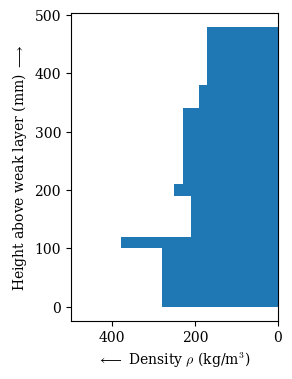

In [34]:
weac.plot.slab_profile(pst_cut_right)

### Analyze skier-induced stresses and deformations
---

In [35]:
# Example with two segements, one skier load
# (between segments 1 & 2) and no crack.

#                   |
#                   v
# +-----------------+-----------------+
# |                 |                 |
# |        1        |        2        |
# |                 |                 |
# +-----------------+-----------------+
#  |||||||||||||||||||||||||||||||||||
# --------------------------------------

In [36]:
# Input
totallength = 1e4                       # Total length (mm)
cracklength = 0                         # Crack length (mm)
inclination = 30                        # Slope inclination (°)
skierweight = 80                        # Skier weigth (kg)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. We
# can choose to analyze the situtation before a crack appears
# even if a cracklength > 0 is set by replacing the 'crack'
# key thorugh the 'nocrack' key.
seg_skier = skier.calc_segments(
    L=totallength, a=cracklength, m=skierweight)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skier = skier.assemble_and_solve(
    phi=inclination, **seg_skier)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xsl (slab). The result is returned in the
# form of the ndarray z. Also provides xwl (weak layer) that only
# contains x-coordinates that are supported by a foundation.
xsl_skier, z_skier, xwl_skier = skier.rasterize_solution(
    C=C_skier, phi=inclination, **seg_skier)

#### Visualize slab deformations (contour plot)

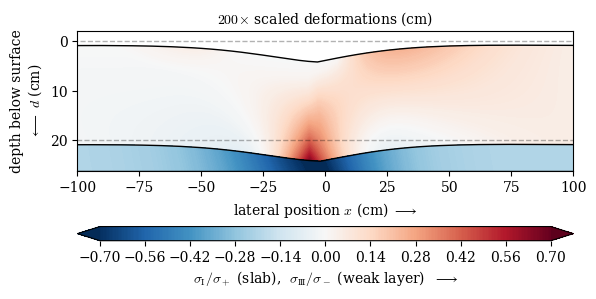

In [37]:
weac.plot.deformed(skier, xsl=xsl_skier, xwl=xwl_skier, z=z_skier,
                   phi=inclination, window=200, scale=200, aspect=2,
                   field='principal')

#### Plot slab displacements

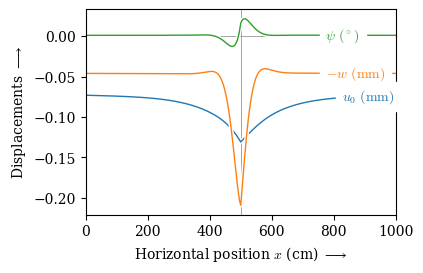

In [38]:
weac.plot.displacements(skier, x=xsl_skier, z=z_skier, **seg_skier)

#### Plot weak-layer stresses

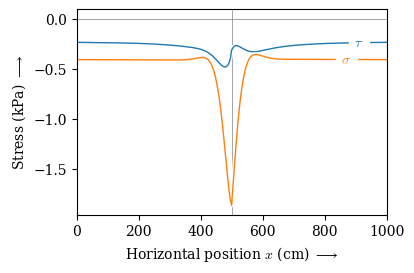

In [39]:
weac.plot.stresses(skier, x=xwl_skier, z=z_skier, **seg_skier)

### Propagation saw test
---

In [40]:
# Example with a crack cut from the right-hand side.

# +-----------------------------+-----+
# |                             |     |
# |             1               |  2  |
# |                             |     |
# +-----------------------------+-----+
#  |||||||||||||||||||||||||||||
# --------------------------------------

In [41]:
# Input
totallength = 2500                      # Total length (mm)
cracklength = 300                       # Crack length (mm)
inclination = -38                       # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations.
# We can choose to analyze the situtation before a crack
# appears even if a cracklength > 0 is set by replacing the
# 'crack' key thorugh the 'uncracked' key.
seg_pst = pst_cut_right.calc_segments(
    L=totallength, a=cracklength)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_pst = pst_cut_right.assemble_and_solve(
    phi=inclination, **seg_pst)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xsl (slab). The result is returned in the
# form of the ndarray z. Also provides xwl (weak layer) that only
# contains x-coordinates that are supported by a foundation.
xsl_pst, z_pst, xwl_pst = pst_cut_right.rasterize_solution(
    C=C_pst, phi=inclination, **seg_pst)

#### Visualize slab deformations (contour plot)

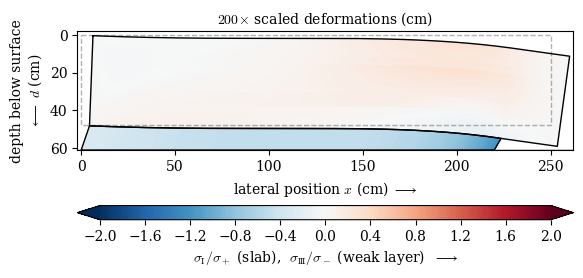

In [42]:
weac.plot.deformed(pst_cut_right, xsl=xsl_pst, xwl=xwl_pst,
                   z=z_pst, phi=inclination, scale=200,
                   aspect=1, field='principal')

#### Plot slab deformations

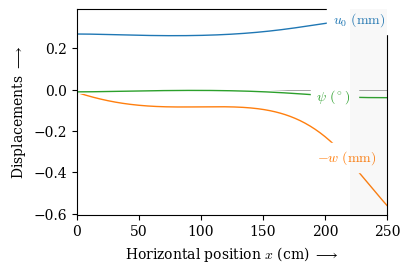

In [43]:
weac.plot.displacements(pst_cut_right, x=xsl_pst, z=z_pst, **seg_pst)

#### Plot weak-layer stresses

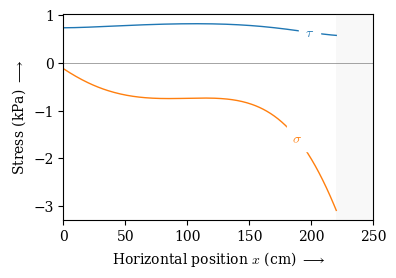

In [44]:
weac.plot.stresses(pst_cut_right, x=xwl_pst, z=z_pst, **seg_pst)

### Energy release rate in propagation saw tests
---

In [45]:
# Input
totallength = 1200                      # Total length (mm)
cracklength = 400                       # Maximum crack length (mm)
inclination = 30                        # Slope inclination (°)
n = 50                                  # Number of crack increments

# Initialize outputs and crack lengths
Gdif = np.zeros([3, n])
Ginc = np.zeros([3, n])
da = np.linspace(1e-6, cracklength, num=n)

# Loop through crack lengths
for i, a in enumerate(da):
    
    # Obtain lists of segment lengths, locations of foundations.
    seg_err = pst_cut_right.calc_segments(L=totallength, a=a)
    
    # Assemble system and solve for free constants
    C0 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['nocrack'])
    C1 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['crack'])
    
    # Compute differential and incremental energy release rates
    Gdif[:, i] = pst_cut_right.gdif(C1, inclination, **seg_err['crack'])
    Ginc[:, i] = pst_cut_right.ginc(C0, C1, inclination, **seg_err['both'])

#### Plot differential energy release rate

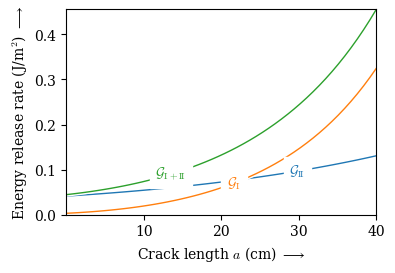

In [46]:
weac.plot.err_modes(da, Gdif, kind='dif')

### Multiple skiers
----

In [47]:
# Example with six segements, two skier loads (between
# segments 1 & 2 and 2 & 3) and a crack under segments
# 4 and 5

#           |   |
#           v   v
# +---------+---+-----+---+---+-------+
# |         |   |     |   |   |       |
# |    1    | 2 |  3  | 4 | 5 |   6   |
# |         |   |     |   |   |       |
# +---------+---+-----+---+---+-------+
#  |||||||||||||||||||         |||||||
# --------------------------------------

In [48]:
# Input
li = [5e3, 10e2, 25e2, 3e2, 3e2, 5e3]           # Beam segment lengths (mm)
ki = [True, True, True, False, False, True]     # Foundation (bedded/free = True/False)
mi = [80, 80, 0, 0, 0]                          # Skier weights [kg]
inclination = -20                               # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. If,
# in addition, a list k0 is passed to calc_segments, we may
# replace the 'crack' key by the 'nocrack' key to toggle
# between cracked (ki) and uncracked (k0) configurations.
seg_skiers = skiers_on_B.calc_segments(
    li=li, ki=ki, mi=mi)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skiers = skiers_on_B.assemble_and_solve(
    phi=inclination, **seg_skiers)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xsl (slab). The result is returned in the
# form of the ndarray z. Also provides xwl (weak layer) that only
# contains x-coordinates that are supported by a foundation.
xsl_skiers, z_skiers, xwl_skiers = skiers_on_B.rasterize_solution(
    C=C_skiers, phi=inclination, **seg_skiers)

#### Visualize slab deformations (contour plot)

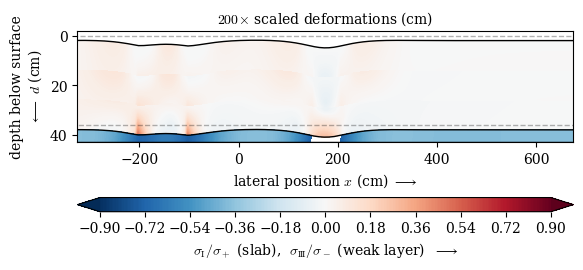

In [49]:
weac.plot.deformed(
    skiers_on_B, xsl=xsl_skiers, xwl=xwl_skiers, z=z_skiers,
    phi=inclination, window=1e3, scale=200, aspect=5,
    field='principal')

#### Plot slab displacements

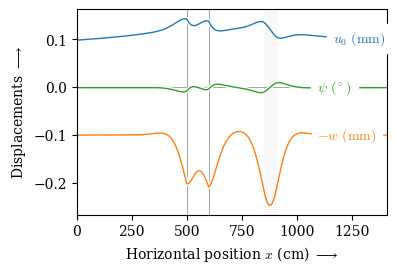

In [50]:
weac.plot.displacements(skiers_on_B, x=xsl_skiers, z=z_skiers, **seg_skiers)

#### Plot weak-layer stresses

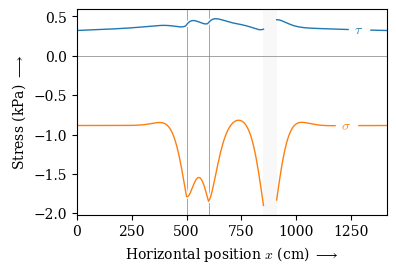

In [51]:
weac.plot.stresses(skiers_on_B, x=xwl_skiers, z=z_skiers, **seg_skiers)

#### Compare all outputs

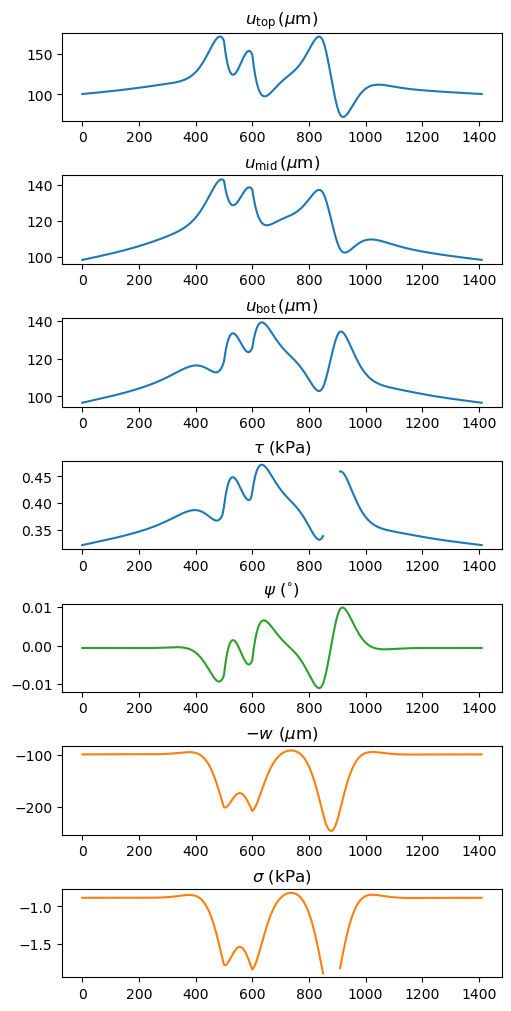

In [52]:
# === WEAK-LAYER OUTPUTS ===================================================

# Use only x-coordinates of bedded segments (xb)
x, z = xwl_skiers, z_skiers

# Compute stresses in kPa
xwl_cm, tau = skiers_on_B.get_weaklayer_shearstress(x=x, z=z, unit='kPa')
_, sig = skiers_on_B.get_weaklayer_normalstress(x=x, z=z, unit='kPa')

# === SLAB OUTPUTS ==========================================================

# Use x-coordinates of bedded and unsupported segments (xq)
x, z = xsl_skiers, z_skiers

# Compute deformations in um and degrees
xsl_cm, w = skiers_on_B.get_slab_deflection(x=x, z=z, unit='um')
_, u_top = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='top')
_, u_mid = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='mid')
_, u_bot = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='bot')
_, psi = skiers_on_B.get_slab_rotation(x=x, z=z, unit='degrees')

# === ASSEMBLE ALL OUTPUTS INTO LISTS =======================================

outputs = [u_top, u_mid, u_bot, tau, psi, -w, sig]

names = [
    r'$u_\mathrm{top}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{mid}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{bot}\,(\mu\mathrm{m})$',
    r'$\tau\ (\mathrm{kPa})$',
    r'$\psi\ (\!^\circ\!)$',
    r'$-w\ (\mu\mathrm{m})$',
    r'$\sigma\ (\mathrm{kPa})$'
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
coloridx = [0, 0, 0, 0, 2, 1, 1]

# === PLOT ALL OUTPUTS ======================================================

fig, axs = plt.subplots(7, 1, constrained_layout=True, figsize=(5,10))
for i, ax in enumerate(fig.get_axes()):
    ax.plot(xsl_cm, outputs[i], color=colors[coloridx[i]])
    ax.set_title(names[i])

### Checking criteria for anticrack nucleation and crack propagation

In [53]:
import sys
sys.path.append('../weac')  # Adds the 'weac' folder to the Python path

In [54]:
from criterion_check import *

In [55]:
# Define test parameters
snow_profile = [[170, 100],  # (1) surface layer
             [190,  40],  # (2) 2nd layer
             [230, 130],  #  :
             [250,  20],  #  :
             [210,  70],  # (i) i-th layer
             [380,  20],  #  :
             [280, 100]]  # (N) last slab layer above weak layer

phi = 30  # Slope angle in degrees
skier_weight = 75  # Skier weight in kg
envelope = 'adam_unpublished'
scaling_factor = 1
E = 0.25  # Elastic modulus in MPa
order_of_magnitude = 1
density = 150  # Weak layer density in kg/m³
t = 30  # Weak layer thickness in mm

# Call the method
(
    result,
    crack_length,
    skier_weight,
    skier,
    C,
    segments,
    x_cm,
    sigma_kPa,
    tau_kPa,
    iteration_count,
    elapsed_times,
    skier_weights,
    crack_lengths,
    self_collapse,
    pure_stress_criteria,
    critical_skier_weight,
    g_delta_last,
    dist_max,
    g_delta_values,
    dist_max_values,
) = check_coupled_criterion_anticrack_nucleation(
    snow_profile=snow_profile,
    phi=phi,
    skier_weight=skier_weight,
    envelope=envelope,
    scaling_factor=scaling_factor,
    E=E,
    order_of_magnitude=order_of_magnitude,
    density=density,
    t=t,
)

# Print the results
print("Algorithm convergence:", result)
print("Anticrack nucleation governed by a pure stress criterion:", pure_stress_criteria)

print("Critical Skier Weight:", skier_weight, "kg")
print("Crack Length:", crack_length, "mm")
print("Fracture toughness envelope function:", g_delta_values[-1])
print("Stress failure envelope function:", dist_max_values[-1])

Algorithm convergence: True
Anticrack nucleation governed by a pure stress criterion: True
Critical Skier Weight: 493.96969093916425 kg
Crack Length: 1 mm
Fracture toughness envelope function: 775.8710825052028
Stress failure envelope function: 1.0038504429239823


As the fracture toughness envelope function is greater than one for the minimum critical skier weight, this particular snow profile is governed by a pure stress criterion for anticrack nucleation. 

In [56]:
# Define thinner snow profile (standard snow profile A), with higher weak layer Young's Modulus
snow_profile = [[350, 120],  # (1) surface layer
             [270,  120],  # (2) 2nd layer
             [180, 120]]  # (N) last slab layer above weak layer

phi = 30  # Slope angle in degrees
skier_weight = 75  # Skier weight in kg
envelope = 'adam_unpublished'
scaling_factor = 1
E = 1  # Elastic modulus in MPa
order_of_magnitude = 1
density = 150  # Weak layer density in kg/m³
t = 30  # Weak layer thickness in mm

(
    result,
    crack_length,
    skier_weight,
    skier,
    C,
    segments,
    x_cm,
    sigma_kPa,
    tau_kPa,
    iteration_count,
    elapsed_times,
    skier_weights,
    crack_lengths,
    self_collapse,
    pure_stress_criteria,
    critical_skier_weight,
    g_delta_last,
    dist_max,
    g_delta_values,
    dist_max_values,
) = check_coupled_criterion_anticrack_nucleation(
    snow_profile=snow_profile,
    phi=phi,
    skier_weight=skier_weight,
    envelope=envelope,
    scaling_factor=scaling_factor,
    E=E,
    order_of_magnitude=order_of_magnitude,
    density=density,
    t=t,
)

# Print the results
print("Algorithm convergence:", result)
print("Anticrack nucleation governed by a pure stress criterion:", pure_stress_criteria)

print("Critical Skier Weight:", skier_weight, "kg")
print("Crack Length:", crack_length, "mm")
print("Fracture toughness envelope function:", g_delta_values[-1])
print("Stress failure envelope function:", dist_max_values[-1])

Algorithm convergence: True
Anticrack nucleation governed by a pure stress criterion: False
Critical Skier Weight: 346.65085429332703 kg
Crack Length: 29.020273891394027 mm
Fracture toughness envelope function: 1.0002587893165604
Stress failure envelope function: 1.0306218152961808


The thinner snow profile, with adjusted weak layer Young's Modulus, is governed by a coupled criterion for anticrack nucleation. The critical skier weight is 346.7 kg and the associated crack length is 29 mm.

In [57]:
# Evaluate crack propagation criterion for the found anticrack
g_delta_diff, crack_propagation_criterion_check = check_crack_propagation_criterion(
    snow_profile=snow_profile,
    phi=phi,
    segments=segments,
    skier_weight=0,
    E=E,
    t=t
)

# Print the results
print("Fracture toughness envelope function:", g_delta_diff)
print("Crack Propagation Criterion Met:", crack_propagation_criterion_check)

Fracture toughness envelope function: 4.7166366294665635e-05
Crack Propagation Criterion Met: False


In [58]:
# As the crack propagation criterion is not met --> investigate minimum self propagation crack boundary
initial_interval = (1, 3000)  # Interval for the crack length search (mm)

min_crack_length = find_min_crack_length_self_propagation(
    snow_profile=snow_profile,
    phi=phi,
    E=E,
    t=t,
    initial_interval=initial_interval
)

if min_crack_length is not None:
    print(f"Minimum Crack Length for Self-Propagation: {min_crack_length} mm")
else:
    print("The search for the minimum crack length did not converge.")

Minimum Crack Length for Self-Propagation: 1706.390802276992 mm


The anticrack of 29.0 mm is not sufficiently long to surpass the self crack propagation boundary of 1706.4 mm. The propensity of the generated anticrack to proagate, is low.

In [59]:
# So far, stress envelope boundary has not scaled with weak layer density
# --> Update scaling factor using density baseline of 250 kg/m^3 and order of magnitude of 3, 
#     as this has shown closest resemblance to previously published failure envelopes

snow_profile = [[350, 120],  # (1) surface layer
             [270,  120],  # (2) 2nd layer
             [180, 120]]  # (N) last slab layer above weak layer

phi = 35  # Slope angle in degrees
skier_weight = 75  # Skier weight in kg
envelope = 'adam_unpublished'
E = 1 # Elastic modulus in MPa
order_of_magnitude = 3
density = 125  # Weak layer density in kg/m³
t = 30  # Weak layer thickness in mm
density_baseline = 250
scaling_factor = density / density_baseline

(
    result,
    crack_length,
    skier_weight,
    skier,
    C,
    segments,
    x_cm,
    sigma_kPa,
    tau_kPa,
    iteration_count,
    elapsed_times,
    skier_weights,
    crack_lengths,
    self_collapse,
    pure_stress_criteria,
    critical_skier_weight,
    g_delta_last,
    dist_max,
    g_delta_values,
    dist_max_values,
) = check_coupled_criterion_anticrack_nucleation(
    snow_profile=snow_profile,
    phi=phi,
    skier_weight=skier_weight,
    envelope=envelope,
    scaling_factor=scaling_factor,
    E=E,
    order_of_magnitude=order_of_magnitude,
    density=density,
    t=t,
)


print("Algorithm convergence:", result)
print("Anticrack nucleation governed by a pure stress criterion:", pure_stress_criteria)
print("Critical Skier Weight:", skier_weight, "kg")
print("Crack Length:", crack_length, "mm")
print("Fracture toughness envelope function:", g_delta_values[-1])
print("Stress failure envelope function:", dist_max_values[-1])

Algorithm convergence: True
Anticrack nucleation governed by a pure stress criterion: False
Critical Skier Weight: 22.554150952829684 kg
Crack Length: 2343.7337508472374 mm
Fracture toughness envelope function: 1.0001387368634147
Stress failure envelope function: 1.5945729403688182


In [60]:
# Evaluate crack propagation criterion for the found anticrack

g_delta_diff, crack_propagation_criterion_check = check_crack_propagation_criterion(
    snow_profile=snow_profile,
    phi=phi,
    segments=segments,
    skier_weight=0,
    E=E,
    t=t
)

print("Fracture toughness envelope function:", g_delta_diff)
print("Crack Propagation Criterion Met:", crack_propagation_criterion_check)

Fracture toughness envelope function: 43.354331761371924
Crack Propagation Criterion Met: True


Crack propagation is expected given the anticrack nucleation length of 2343.7 mm. Scaling stress envelope boundary and weak layer Young's Modulus with weak layer density is essential for fair evaluation of anticrack and crack propagation criteria. 